При подготовке ноутбука использовались материалы:
1. [LDA topic modelling lenta Kaggle](https://www.kaggle.com/genyagree/lda-topic-modelling/notebook)
2. [LDA topic modelling visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
3. [LDA topic modelling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

# Введение
**Latent Dirichlet Allocation** (LDA) - статистическая модель, позволяющая разделить набор текстов на $N$ подгрупп.

Каждый кластер характеризуется набором из $X$ ключевых слов. Эти ключевые слова ассоциируются с темой (topic). 

Каждый документ может быть представлен абором тем, каждая тема может быть представлена набором ключевых слов.

### Пример
У нас есть 3 документа:<br>
<br>
D1 = "Собаки любят играть"<br>
D2 = "Кошки любят молоко"<br>
D3 = "Кошки и собаки любят кушать и играть. Я люблю собак. Они милые"<br>

Topic Modelling может выдать следующую модель:<br>
<br>
D1 = 100% Topic1 + 0% Topic2<br>
D2 = 0% Topic1 + 100% Topic2<br>
D3 = 70% Topic1 + 30% Topic2<br>
<br>
Где каждая тема сформирована из слов (в порядке убывания значимости):<br>
<br>
Topic1 = 30% собака, 30% играть, 20% нравиться 10% милая 10% любить<br>
Topic2 = 50% кошка, 30% молоко, 20% нравиться<br>



# Зачем нужно LDA Topic Modeling

Общая задача тематического моделирования - обнаружение скрытой структуры в наборе текстовых данных. 
Для маленького количества текстов мы могли бы использовать просто tf-idf информацию, но для большого числа документов этого уже не достаточно

Практические применения:

1. [Суммаризация мнений](https://dl.acm.org/doi/10.1145/1076034.1076161)
Управляющим организациям, чьи решения влияют на большие группы людей может быть полезно суммаризовать информацию с выражением мнений из открытых источников (постов и комментариев в соцсетях)

2. [Bioinformatics](https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8)
Применение метода к "microarray datasets" - датасетам с последовательностями аминокилот или нуклеотидов - для выявления сткрытой структуры этих данных.

3. [Отслеживание трендов в тематиках корпусов текстов](https://timreview.ca/article/1170)
Анализ корпуса текстов - научных публикаций на определенную тему - позволяет отследить, как меняется взгляд на ту или иную научную проблему

4. [Рекомендательные системы](https://habr.com/ru/company/surfingbird/blog/150607/)
Если представить пользователя как набор описания продуктов, которые ему понравились, то можно находить тематики, интересующие пользователя и делать рекомендации в соответствии с ними.



   
# Немного теории
В latent diriclet allocaton (LDA) модели каждый документ в корпусе представляется в виде набора тем в соответствии с распределением Дирихле.

##  Постановка проблемы
- Коллекция документов $D$
- Каждый документ $d$ из коллекции представлен набором слов $W_{d} = (w_{1}, ..., w_{n_{d}})$ из словаря $W$, где $n_{d}$ - длина документа $d$
- Каждому документу соответствует набор тем
- Порядком слов в документе пренебрегают: каждый документ рассматривается как bag-of-words
- Каждая тема $t\in T$ (где $T$ - набор тем) описывается распределением Дирихле $p(w|t)$ на наборе слов $w\in W$, то есть тема представлена в виде вектора $\phi_{t} = (p(w|t):w \in W)$
- Каждый документ $d\in D$ описывается распределением Дирихле $p(t|d)$ на наборе тем $t\in T$. То есть документ описывается вектором $\theta_{d} = (p(t|d):t \in T)$
<br>

![](https://editor.analyticsvidhya.com/uploads/26864dtm.JPG)

Вероятность "возникновения" пары "документ-слово" можно записать следующим образом:

$$
p(w|d)=\sum\limits_{t\in T}p(w|t)p(t|d)
$$

![](https://miro.medium.com/max/780/1*QiTvyHNwvGI5UCqeKvhNsg.png)

## Решение
Построить модель тематического моделирования значит найти матрицы $\Phi = ||p(w|t)||$ и $\Theta = ||p(t|d)||$ на основе коллекции документов $D$.


Для нахождения решения нужно ршеить оптимизационную задачу - максимизировать следующую функцию (максимизируем likelihood наших данных с такими матрицами): 
$$
\sum\limits_{d\in D}\sum\limits_{w\in d}n_{dw}logp(w|d)\to\max\limits_{\Phi,\Theta},
$$
где $n_{dw}$ - частота слова $w$ в документе $d$.

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Загрузка данных

In [ ]:
DATA_DIR = "data"
DATA_FILE = "lenta-ru-news.csv"

In [ ]:
rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE)).dropna()

/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
rus_data.head()

url  \
0   https://lenta.ru/news/1914/09/16/hungarnn/   
1  https://lenta.ru/news/1914/09/16/lermontov/   
2  https://lenta.ru/news/1914/09/17/nesteroff/   
3   https://lenta.ru/news/1914/09/17/bulldogn/   
4       https://lenta.ru/news/1914/09/18/zver/   

                                               title  \
0  1914. Русские войска вступили в пределы Венгрии     
1  1914. Празднование столетия М.Ю. Лермонтова от...   
2                           1914. Das ist Nesteroff!   
3                    1914. Бульдог-гонец под Льежем    
4           1914. Под Люблином пойман швабский зверь   

                                                text       topic  \
0  Бои у Сопоцкина и Друскеник закончились отступ...  Библиотека   
1  Министерство народного просвещения, в виду про...  Библиотека   
2  Штабс-капитан П. Н. Нестеров на днях, увидев в...  Библиотека   
3  Фотограф-корреспондент Daily Mirror рассказыва...  Библиотека   
4  Лица, приехавшие в Варшаву из Люблина, передаю...  Библиотека   

             tags        date  
0  Первая мировая  1914/09/16  
1  Первая мировая  1914/09/16  
2  Первая мировая  1914/09/17  
3  Первая мировая  1914/09/17  
4  Первая мировая  1914/09/18

In [ ]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [ ]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

In [ ]:
rus_data[(rus_data['topic']!='Библиотека')&(rus_data['topic']!='Бывший СССР')&(rus_data['topic']!='69-я параллель')]

url  \
5       https://lenta.ru/news/1999/08/31/stancia_mir/   
6             https://lenta.ru/news/1999/08/31/vzriv/   
7       https://lenta.ru/news/1999/08/31/credit_japs/   
8             https://lenta.ru/news/1999/08/31/diana/   
9               https://lenta.ru/news/1999/08/31/mvf/   
...                                               ...   
739169  https://lenta.ru/news/2018/12/15/putin_polet/   
739171   https://lenta.ru/news/2018/12/15/gasinparis/   
739173          https://lenta.ru/news/2018/12/15/spb/   
739174        https://lenta.ru/news/2018/12/15/gizin/   
739175  https://lenta.ru/news/2018/12/15/rap_n_drugs/   

                                                    title  \
5              Космонавты сомневаются в надежности "Мира"   
6            Взрыв в центре Москвы: пострадало 30 человек   
7       Япония кредитует Россию на полтора миллиарда д...   
8                Британцы отмечают двухлетие смерти Дианы   
9       Отмытые через Bank of NY деньги не имели отнош...   
...                                                   ...   
739169  Путин подарил тяжелобольному мальчику обещанны...   
739171  «Желтые жилеты» прорвали кордон полиции под «М...   
739173           В Петербурге нашли квартиру из 58 комнат   
739174  Падение горнолыжника на полной скорости попало...   
739175  Путин порассуждал о сексе, наркотиках и протес...   

                                                     text   topic  \
5       Как стало известно агентству Ассошиэйтед Пресс...  Россия   
6       В зале игровых автоматов в третьем ярусе подзе...  Россия   
7       Япония приняла решение разморозить кредиты Рос...  Россия   
8       Британцы отмечают сегодня скорбную дату - втор...     Мир   
9       В понедельник директор департамента внешних св...  Россия   
...                                                   ...     ...   
739169  Президент России Владимир Путин организовал дл...  Россия   
739171  Протесты движения «желтых жилетов» в Париже сн...     Мир   
739173  В Московском районе Санкт-Петербурга на продаж...     Дом   
739174  Швейцарский горнолыжник Марк Гизин неудачно пр...   Спорт   
739175  Президент России Владимир Путин рассказал, что...  Россия   

                tags        date  
5                Все  1999/08/31  
6                Все  1999/08/31  
7                Все  1999/08/31  
8                Все  1999/08/31  
9                Все  1999/08/31  
...              ...         ...  
739169      Политика  2018/12/15  
739171  Происшествия  2018/12/15  
739173      Квартира  2018/12/15  
739174   Зимние виды  2018/12/15  
739175      Политика  2018/12/15  

[659951 rows x 6 columns]

## Чистка данных

In [ ]:
def clean_data(df):
    rusdata_df = df[(df['topic']!='Библиотека')&(df['topic']!='Бывший СССР')&(df['topic']!='69-я параллель')].reset_index(drop=True).sample(10000, random_state = 42)
    rusdata = rusdata_df['text']
    return rusdata_df, rusdata

In [ ]:
rusdata_df, rusdata = clean_data(rus_data)

In [ ]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

In [ ]:
print(len(rusdata))

10000


# Обработка данных

### Токенизация

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/vas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha())

In [ ]:
data = [process(t) for t in rusdata]

## Лемматизация

In [ ]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [ ]:
morph_data = lemmatizer(data)

In [ ]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [ ]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

 ## Удаление стоп-слов

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [ ]:
STOPWORDS_DIR = "stopwords"

In [ ]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

In [ ]:
stopwordsru = get_stop_words()

In [ ]:
data_without_swords = []
for words in data_norm:
    for_append = []
    for word in words:
        if word not in stopwordsru:
            for_append.append(word)
    data_without_swords.append(for_append)

# Визуализация

In [ ]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

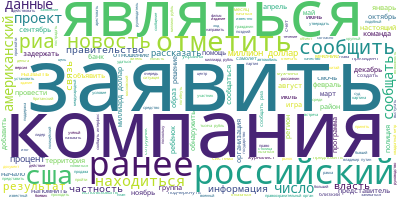

In [ ]:
wordcloud_visualization(data_without_swords)

## Построение n-грамм

*Смотри документацию [Phrases](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) и [Phraser](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.FrozenPhrases). Phraser ускоряет работу Phrases*

In [ ]:
bigram = gensim.models.Phrases(data_without_swords, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_without_swords], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(data_without_swords)

In [ ]:
print(data_words_trigrams[0])

['завод', 'салфита', 'западный_берег', 'израильский', 'военный', 'обнаружить', 'называть', 'пояс_шахид', 'предназначить', 'совершение_теракт', 'посредством', 'самоубийство', 'сообщать', 'издание', 'сведение', 'израильский', 'спецслужба', 'исламский', 'экстремист', 'подготовить', 'сто', 'планироваться', 'направить', 'иерусалим', 'данные', 'источник', 'финансировать', 'подобный', 'процесс', 'подготовка', 'теракт', 'структура', 'базироваться', 'саудовский_аравия', 'агентство', 'выяснить', 'накануне', 'саудовский_аравия', 'счёт', 'семья', 'самоубийца', 'джамаль', 'нассера', 'поступить', 'тысяча', 'доллар', 'совершить', 'теракт', 'район', 'наблус', 'врезаться', 'автобус', 'загрузить', 'взывчатка', 'подобный', 'платёж', 'семья', 'погибнуть', 'палестинский', 'террорист', 'регулярно', 'проходить', 'саудовский_аравия', 'утверждать', 'источник', 'среда', 'министр_внутренний', 'саудовский_аравия', 'найефа', 'бин', 'приказать', 'перечислить', 'миллион_доллар', 'счёт', 'некий', 'палестинский', 'бла

## Создание словаря n-gram и BOW

*Смотри документацию [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary) и [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).*

In [ ]:
dictionary = corpora.Dictionary(data_words_trigrams)

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams]
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [ ]:
dictionary[8]

'взывчатка'

In [ ]:
len(corpus)

10000

## Encoding Tf-Idf

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

[Статья с хорошим описанием](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

$t$ — term (word)<br>
$d$ — document (set of words)<br>
$D$ - коллекция документов<br>
$N$ — размер коллекции документов $D$<br>


$$tf(t,d) = \frac{n_{td}}{n_{d}}$$
Частота встречаемости слова в документе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$df(t) = \sum_d{n_{td}}$$
Встречаемость слова в корпусе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$idf(t) = log(\frac{N}{df(t)+1})$$
Обратная встречаемость слова в корпусе.<br>
<br>

**$$tfidf(t,d) = tf(t,d)*idf(t)$$**

In [ ]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary)

In [ ]:
corpus_tfidf = tfidf[corpus]

In [ ]:
tfidf

In [ ]:
corpus_tfidf

# Построение модели LDA Topic Modelling

## Использование корпуса без TF-IDF фильтрации

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.show_topics(formatted=False))

[(2,
  [('двигатель', 0.105232656),
   ('прим', 0.10038912),
   ('длинный', 0.04864251),
   ('изделие', 0.04570454),
   ('бутерброд', 1.0938329e-05),
   ('зиг', 1.0938329e-05),
   ('заголо', 1.0938329e-05),
   ('всто', 1.0938329e-05),
   ('поджарить', 1.0938329e-05),
   ('лавриновый', 1.0938329e-05)]),
 (78,
  [('обращение', 0.23677173),
   ('отчёт', 0.13895532),
   ('тяжёлый_состояние', 0.021252692),
   ('барбекю', 9.422337e-06),
   ('всто', 9.422337e-06),
   ('поджарить', 9.422337e-06),
   ('гриль', 9.422337e-06),
   ('бутерброд', 9.422337e-06),
   ('заголо', 9.422337e-06),
   ('галифакс', 9.422337e-06)]),
 (38,
  [('нефть', 0.22420196),
   ('саудовский_аравия', 0.08107534),
   ('предназначить', 0.07714643),
   ('конструкция', 0.062875055),
   ('образоваться', 0.039890762),
   ('затонуть', 0.03111924),
   ('добывать', 0.018841809),
   ('подводный', 0.012347265),
   ('поджарить', 7.0710075e-06),
   ('гриль', 7.0710075e-06)]),
 (11,
  [('приобрести', 0.15134346),
   ('супруг', 0.122306

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

Dominant_Topic1 Dominant_Topic2 %Topic_Contribution1 %Topic_Contribution2  \
0               3              13               0.1577               0.1118   
1              47              21               0.2923                0.063   
2              21              15               0.2028                0.134   
3              12              21               0.2504               0.0881   
4              32              21               0.2973               0.0699   
5              53              69               0.4485               0.0618   
6              22              21               0.3058               0.0763   
7              30              21               0.3803               0.1005   
8              60              21               0.2594               0.0619   
9               0              21               0.1926               0.0792   

                                     Topic_Keywords1  \
0  теракт, террорист, подготовка, израильский, сп...   
1  сообщать, представитель, власть, июль, террито...   
2  заявить, российский, решение, ноябрь, май, июн...   
3  март, январь, международный, действие, пройти,...   
4  газета, роман, институт, зал, сотрудничать, бо...   
5  игра, счёт, матч, сборная, победа, чемпионат, ...   
6  военный, цель, ирак, американец, станция, допо...   
7  продажа, производство, помимо, позволять, заво...   
8  тысяча, миллион, рубль, миллион_доллар, доллар...   
9  создать, качество, заниматься, собственный, де...   

                                     Topic_Keywords2  \
0  результат, информация, сообщить, данные, агент...   
1  заявить, российский, решение, ноябрь, май, июн...   
2  изменение, благодаря, сокращение, оператор, го...   
3  заявить, российский, решение, ноябрь, май, июн...   
4  заявить, российский, решение, ноябрь, май, июн...   
5  команда, клуб, матч, нынешний, игрок, сезон, н...   
6  заявить, российский, решение, ноябрь, май, июн...   
7  заявить, российский, решение, ноябрь, май, июн...   
8  заявить, российский, решение, ноябрь, май, июн...   
9  заявить, российский, решение, ноябрь, май, июн...   

                                                text  
0  На одном из заводов в городе Салфит на Западно...  
1  Госсекретарь США Колин Пауэлл вновь встретился...  
2  МТС предложила сократить срок эмбарго на строи...  
3  Экс-чемпион мира по боксу Константин Цзю посту...  
4  Народный художник России, кинодекоратор Алекса...  
5  Мадридский "Реал" обеспечил себе победу в чемп...  
6  Бюджетный комитет федерального парламента Герм...  
7  Продажи нового бюджетного седана Nissan Almera...  
8  Двое американцев, занимавшихся мошенничеством ...  
9  Более четверти бывших министров администрации ...

In [ ]:
df_dominant_topic.loc[2]["text"]

'МТС предложила сократить срок эмбарго на строительство сетей стандарта связи LTE в Краснодарском крае для тех операторов, которые не являются партнерами Олимпийских игр в Сочи, пишет «Коммерсантъ». Эмбарго предлагается отменить в конце 2014 года, тогда как сейчас оно действует до декабря 2016 года. МТС направила соответствующее письмо в Минсвязи. Компания отмечает, что является лидером по количеству абонентов в крае и ограничение на строительство новых сетей рассматривает как несправедливое. Как передает издание, 2 июля комиссия по радиочастотам (ГКРЧ) может рассмотреть сокращение срока эмбарго, но решение будет отрицательным, поскольку против этого выступил Роскомнадзор. Кроме того, решение установлено федеральным законом, так что у ГКРЧ может не оказаться полномочий, чтобы его отменить. Услуги в ходе Олимпиады могут оказывать «МегаФон» и «Ростелеком», являющиеся ее генеральными партнерами. В других же компаниях решение об эмбарго до конца 2016 года считают «технической ошибкой», пос

In [ ]:
df_dominant_topic.loc[2]["Topic_Keywords1"]

'заявить, российский, решение, ноябрь, май, июнь, принять, декабрь, ранее, связь'

In [ ]:
df_dominant_topic.to_csv('./results/dominant_topic_no_tfidf_limit.csv', index= False)

## Визуализация

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_no_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_no_tfidf_limits' +'.html')
LDAvis_prepared

/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21    -0.252088  0.185033       1        1  8.782939
47    -0.250712  0.094652       2        1  7.711013
50    -0.239703  0.150535       3        1  7.412641
13    -0.244699  0.295592       4        1  6.326813
54    -0.202198 -0.126014       5        1  3.523631
...         ...       ...     ...      ...       ...
9      0.163254  0.023283      76        1  0.199357
11     0.156777  0.022758      77        1  0.186793
38     0.161399  0.023138      78        1  0.153564
78     0.192813  0.024946      79        1  0.087385
2      0.207330  0.025400      80        1  0.060141

[80 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
164     компания  6237.000000  6237.000000  Default  30.0000  30.0000
83      сообщать  9747.000000  9747.000000  Default  29.0000  29.0000
1141     процент  5559.000000  5559.000000  Default  28.0000  28.0000
89           сша  4918.000000  4918.000000  Default  27.0000  27.0000
92        тысяча  4416.000000  4416.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
20         завод     0.006492   541.242558  Topic80 -11.4232  -3.9148
21     загрузить     0.006492    40.725830  Topic80 -11.4232  -1.3278
22    заниматься     0.006492  1151.734532  Topic80 -11.4232  -4.6699
24      заявлять     0.006492   427.172524  Topic80 -11.4232  -3.6781
25     иерусалим     0.006492    96.628519  Topic80 -11.4232  -2.1918

[2905 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2912     20  0.995293               afp
374       8  0.994769            agence
3983     52  0.945019               all
437      40  0.985963               and
582       4  0.997250  associated_press
...     ...       ...               ...
766       7  0.999158            январь
580       8  0.997298            япония
823      48  0.996209          японский
1962     43  0.942569         ярославль
3981     21  0.986544              ясно

[2216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 48, 51, 14, 55, 76, 13, 28, 25, 52, 61, 57, 9, 46, 54, 11, 1, 41, 58, 23, 31, 21, 18, 75, 53, 5, 70, 74, 15, 32, 27, 29, 26, 49, 72, 37, 24, 59, 47, 60, 7, 20, 77, 68, 80, 50, 33, 73, 64, 66, 36, 34, 40, 42, 44, 30, 8, 78, 35, 17, 16, 71, 6, 4, 38, 43, 67, 19, 65, 69, 63, 2, 45, 62, 56, 10, 12, 39, 79, 3])

In [ ]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

ImportError: cannot import name 'ENGLISH_CONNECTOR_WORDS' from 'gensim.models.phrases' (/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/gensim/models/phrases.py)

In [ ]:
sentences = Text8Corpus(datapath('testcorpus.txt'))
phrases = Phrases(sentences, min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)

NameError: name 'ENGLISH_CONNECTOR_WORDS' is not defined

# Оценка качества

### Perplexity

[Подробное описание](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)


Оценка генеративной языковой модели.

Мы хотим, чтобы наша языковая модель приписывала высокие вероятности реальным предложениям и низкие - нереальным. Поэтому чем ниже PP, тем лучше.


$PP(W)$ - обратная вероятность тестового корпуса слов, нормированная на его размер

$$PP(W) = \frac1{P(w_1,...,w_N)^{\frac1N}}$$


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.


Perplexity:  -40.89876618229476


# Задание

## Использование корпуса c TF-IDF фильтрацией (10 баллов)

TFIDF коэффициенты выделяют слова, которые являются часто употребимыми (не несут информации о конкретном документе) или те, которые встречаются только в одном документе и не могут показать скрытую связь между документами. 

В этом задании нужно
1. Найти максимальное и минимальное значение tfidf скора

*Подсказка*: нужно проитерироваться по всему корпусу слов, посчитать tfidf скор и найти пороговые значения

2. Построить дискретный массив tfidf скоров с шагом 0.005 и найти перцентили 10 и 95

3. Отфильтровать corpus в filtered_corpus, оставив только слова со скорами, попадающими в диапазон от 10 до 95 перцентилей.
4. Построить подель LDA на отфильтрованном корпусе
5. Посчитать метрики качества
5. Сделать визуализацию тематик
6. Посмотреть на темы с наибольшими коэффициентами в датафрейме
7. Напишите, какой вывод можно сделать

**Комментарий** - можно уменьшать количество  $n_topics$, если вашему компьютеру не хватает вычислительных мощностей.

**Комментарий** - если при визуализации вы получили ошибку `TypeError: Object of type complex is not JSON serializable`, добавьте в метод `prepare` аргумент `mds='mmds'`

In [ ]:
print('Размер корпуса:', len(corpus_tfidf))
for doc in corpus_tfidf:
    print(type(doc))
    break

scores = [] # возвращает неотсортированный массив скоров для каждого документа
for doc in corpus_tfidf:
    scr_for_list = []
    for word in doc:
        scr_for_list.append(word[1])
    scores.append(scr_for_list)



Размер корпуса: 10000
<class 'list'>


# 1

In [ ]:
max_score_word = []
min_score_word = []

for doc in corpus_tfidf:
    max_score_word.append(max(doc, key=lambda doc: doc[1]))
    min_score_word.append(min(doc, key=lambda doc: doc[1]))


In [ ]:
print(max_score_word[1])
print(min_score_word[0])

(129, 0.3465237552712227)
(83, 0.010641936236930397)


# 2

In [ ]:
import numpy as np
import pandas as pd

dicts = [] # возвращает словари распределений для каждого документа 

for i in range(len(scores)):
    ranges = np.arange(min_score_word[i][1] - 0.005, max_score_word[i][1] + 0.005, 0.005)
    df_scores = pd.Series(scores[i])
    
    splited_arr = df_scores.groupby(pd.cut(df_scores, ranges)).count()
    
    d = {}
    for i in range(len(ranges) - 1):
        d[str(ranges[i]) + '-' + str(ranges[i])] = splited_arr[i]
        
    dicts.append(d)

In [ ]:
lists_percentiles = [] # возвращает интервалы для каждого документа с персентилями

for doc in corpus_tfidf:
    sorted_doc = sorted(doc, key= lambda doc:doc[1])
    lists_percentiles.append([sorted_doc[int(len(sorted_doc) * 0.1)][1], sorted_doc[int(len(sorted_doc) * 0.95)][1]])
    
    
    

In [ ]:
lists_percentiles

[[0.04327010217634356, 0.150264027514669],
 [0.06659391249078297, 0.26434941760475344],
 [0.03937600372972552, 0.17624157799422793],
 [0.042958800057284974, 0.17680024185702262],
 [0.05085118460185529, 0.14707504597092774],
 [0.050444978012575734, 0.24352925205530693],
 [0.04390079365609073, 0.174075846324943],
 [0.02576734537927945, 0.19962361459467312],
 [0.03502475928458765, 0.16645835121573196],
 [0.034243592632430715, 0.2038186070285965],
 [0.03748426477723485, 0.2615123725342681],
 [0.045139107167222914, 0.13396842031451453],
 [0.04742122470984659, 0.18117211372916464],
 [0.03929323297934108, 0.19571523541292046],
 [0.03709743207122973, 0.17987084431164946],
 [0.03954245360780911, 0.20093104433164055],
 [0.058266565434889735, 0.19456062421431128],
 [0.03235027129697119, 0.18279422958817468],
 [0.04699374353785358, 0.1909072630172011],
 [0.03251143296742287, 0.2254872003302154],
 [0.04632354774812294, 0.2169243555655684],
 [0.03820859121054168, 0.1796233914518227],
 [0.04338136243

# 3


In [ ]:
dics_of_counts = []

for doc in corpus:
    dic_of_counts = {}
    for word in doc:
        dic_of_counts[word[0]] = word[1]

    dics_of_counts.append(dic_of_counts)

In [ ]:
# corpus_tfidf
# scores
# lists_percentiles
# dics

filtered_corpus = []

for i in range(len(scores)):
    non_filter_doc = corpus_tfidf[i]
    filtered_doc = []
    for word in non_filter_doc:
        if word[1] > lists_percentiles[i][0] and  word[1] < lists_percentiles[i][1]:
            filtered_doc.append((word[0], dics_of_counts[i][word[0]]))
    filtered_corpus.append(filtered_doc)
    

In [ ]:
filtered_corpus

[[(0, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 2),
  (27, 2),
  (29, 1),
  (31, 1),
  (33, 2),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (57, 1),
  (58, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (72, 1),
  (73, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (90, 2),
  (91, 1),
  (93, 3),
  (94, 2),
  (95, 1),
  (96, 1),
  (97, 1),
  (98, 1),
  (99, 1),
  (100, 1)],
 [(25, 1),
  (48, 1),
  (85, 1),
  (100, 1),
  (101, 1),
  (103, 1),
  (104, 1),


# 4

In [ ]:
my_lda_model = gensim.models.ldamodel.LdaModel(corpus=filtered_corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modell

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=my_lda_model, corpus=filtered_corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

Dominant_Topic1 Dominant_Topic2 %Topic_Contribution1 %Topic_Contribution2  \
0              51              45               0.3039               0.0683   
1              58              45               0.2102                 0.06   
2              21              15               0.3721               0.0836   
3              12               2               0.1344               0.1087   
4              74              15                 0.24               0.0706   
5               2              53               0.3898               0.0878   
6              22              45               0.3141               0.0704   
7              35              30               0.1685               0.1075   
8              60              51               0.2821               0.0695   
9              48              45               0.2076               0.1433   

                                     Topic_Keywords1  \
0  журналист, источник, сотрудник, ситуация, сред...   
1  команда, встреча, игра, пообещать, переговоры,...   
2  решение, международный, являться, александр, с...   
3  американский, подчеркнуть, планировать, отноше...   
4  центральный, роман, народный, подчёркивать, за...   
5  матч, счёт, май, клуб, сборная, чемпионат, поб...   
6  военный, система, условие, использоваться, ком...   
7  план, представить, передача, модель, одновреме...   
8  рубль, доллар, размер, заседание, американец, ...   
9  заниматься, частный, бизнесмен, джон, заняться...   

                                     Topic_Keywords2  \
0  документ, руководитель, государственный, цель,...   
1  документ, руководитель, государственный, цель,...   
2  август, немой, школа, технический, говориться_...   
3  матч, счёт, май, клуб, сборная, чемпионат, поб...   
4  август, немой, школа, технический, говориться_...   
5  октябрь, европейский, европа, германия, нынешн...   
6  документ, руководитель, государственный, цель,...   
7  миллион_доллар, данные, продажа, стоимость, вы...   
8  журналист, источник, сотрудник, ситуация, сред...   
9  документ, руководитель, государственный, цель,...   

                                                text  
0  На одном из заводов в городе Салфит на Западно...  
1  Госсекретарь США Колин Пауэлл вновь встретился...  
2  МТС предложила сократить срок эмбарго на строи...  
3  Экс-чемпион мира по боксу Константин Цзю посту...  
4  Народный художник России, кинодекоратор Алекса...  
5  Мадридский "Реал" обеспечил себе победу в чемп...  
6  Бюджетный комитет федерального парламента Герм...  
7  Продажи нового бюджетного седана Nissan Almera...  
8  Двое американцев, занимавшихся мошенничеством ...  
9  Более четверти бывших министров администрации ...

In [ ]:
pprint(my_lda_model.show_topics(formatted=False))

[(63,
  [('brand', 1.562451e-05),
   ('раскрытый', 1.562451e-05),
   ('поджарить', 1.562451e-05),
   ('гриль', 1.562451e-05),
   ('бутерброд', 1.562451e-05),
   ('барбекю', 1.562451e-05),
   ('заголо', 1.562451e-05),
   ('никифоров', 1.562451e-05),
   ('лить', 1.562451e-05),
   ('делайлом', 1.562451e-05)]),
 (62,
  [('brand', 1.562451e-05),
   ('раскрытый', 1.562451e-05),
   ('поджарить', 1.562451e-05),
   ('гриль', 1.562451e-05),
   ('бутерброд', 1.562451e-05),
   ('барбекю', 1.562451e-05),
   ('заголо', 1.562451e-05),
   ('никифоров', 1.562451e-05),
   ('лить', 1.562451e-05),
   ('делайлом', 1.562451e-05)]),
 (55,
  [('brand', 1.562451e-05),
   ('раскрытый', 1.562451e-05),
   ('поджарить', 1.562451e-05),
   ('гриль', 1.562451e-05),
   ('бутерброд', 1.562451e-05),
   ('барбекю', 1.562451e-05),
   ('заголо', 1.562451e-05),
   ('никифоров', 1.562451e-05),
   ('лить', 1.562451e-05),
   ('делайлом', 1.562451e-05)]),
 (76,
  [('brand', 1.562451e-05),
   ('раскрытый', 1.562451e-05),
   ('по

In [ ]:
df_dominant_topic.to_csv('./results/dominant_topic_with_tfidf_limit.csv', index= False)

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_with_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(my_lda_model, filtered_corpus, dictionary, mds='mmds')
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_with_tfidf_limits' +'.html')
LDAvis_prepared

/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
45     0.557799  0.004643       1        1  6.273269
51     0.280082  0.481270       2        1  5.749975
21     0.420127  0.340361       3        1  4.301551
50    -0.538068 -0.106566       4        1  4.095256
12     0.311498 -0.432246       5        1  3.736854
...         ...       ...     ...      ...       ...
11     0.013411  0.008163      76        1  0.106985
76    -0.013623  0.010034      77        1  0.005620
55    -0.013622  0.010035      78        1  0.005592
63    -0.013622  0.010035      79        1  0.005544
62    -0.013622  0.010036      80        1  0.005544

[80 rows x 5 columns], topic_info=             Term         Freq        Total Category  logprob  loglift
164      компания  4248.000000  4248.000000  Default  30.0000  30.0000
274    российский  3585.000000  3585.000000  Default  29.0000  29.0000
1141      процент  2963.000000  2963.000000  Default  28.0000  28.0000
89            сша  3332.000000  3332.000000  Default  27.0000  27.0000
1136    президент  2466.000000  2466.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
25      иерусалим     0.000657    40.518520  Topic80 -11.0667  -1.2292
26        издание     0.000657   634.130592  Topic80 -11.0667  -3.9797
27    израильский     0.000657   255.761340  Topic80 -11.0667  -3.0717
28     информация     0.000657  1054.214053  Topic80 -11.0667  -4.4880
29      исламский     0.000657   117.473462  Topic80 -11.0667  -2.2936

[2840 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2912     13  0.997756               afp
374       7  0.994956            agence
437      21  0.988784               and
582       7  0.997175  associated_press
1400     24  0.986724               bbc
...     ...       ...               ...
238      23  0.995471             якобы
766      43  0.998817            январь
580      31  0.995078            япония
823      62  0.994115          японский
2484     72  0.918693       ярославский

[1987 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[46, 52, 22, 51, 13, 76, 11, 41, 25, 9, 48, 31, 4, 30, 20, 42, 27, 62, 61, 57, 60, 33, 66, 15, 59, 69, 3, 80, 45, 73, 24, 71, 47, 21, 23, 74, 28, 19, 58, 35, 38, 50, 1, 7, 16, 54, 53, 18, 34, 37, 14, 17, 44, 70, 36, 6, 29, 39, 79, 78, 49, 65, 5, 40, 8, 43, 75, 2, 55, 26, 67, 10, 68, 72, 32, 12, 77, 56, 64, 63])

In [ ]:
print('\nPerplexity: ', my_lda_model.log_perplexity(filtered_corpus))


Perplexity:  -41.211289982596185


Вывод: отфильтровав данные наша модель стала показывать себя немного лучше, но не так значительно

## Дополнительное задание (2 балла)

Постройте LDA Topic modelling модель для [датасета постов о политике с Пикабу](https://www.kaggle.com/atomin/pikabu-politic-posts). 

При построении можете поизменять параметры `alpha` и `beta` для получения более качественной модели.

Какие выводы можно сделать на основе полученной модели?

In [ ]:
P_DATA_DIR = "data_pikabu"
P_DATA_FILE = "pikabu_comments.csv"

In [ ]:
pik_data = pd.read_csv(os.path.join(P_DATA_DIR, P_DATA_FILE)).dropna()

/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
pik_data.head(10)

id                                            postUrl       tag  \
0   1  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
1   2  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
2   3  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
3   4  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
4   5  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
5   6  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
6   7  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
7   8  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
8   9  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   
9  10  https://pikabu.ru/story/ya_za_lukashenko_golos...  Политика   

           author       date_published  \
0  DusheskaViolet  2020-08-13 20:13:21   
1       SirJozhik  2020-08-13 20:17:14   
2          MosDef  2020-08-13 22:31:11   
3          Taista  2020-08-13 21:46:19   
4       SirJozhik  2020-08-13 21:50:46   
5          Taista  2020-08-13 21:52:26   
6     XAXBCZCZAAX  2020-08-13 22:41:47   
7       evgeny8ch  2020-08-13 20:18:58   
8   Pussycat.nose  2020-08-13 20:52:09   
9       SemSemych  2020-08-13 21:04:11   

                                             content  likes  dislikes  
0  \n\t\t\tСо вчерашнего утра всё работает. Но, е...     44         0  
1  \n\t\t\tпотому, что Коленька подписан на клубн...     30         2  
2  \nколенька на жизнь пикабушников за границей, ...      3         0  
3  \nА Лукашенко на сообщество ремонтеров и уголо...      5         5  
4  \n\t\t\tа ремонтеры чем провинились?\n\t\t\t\t...      1         0  
5   \nНичем. Лукашенке просто посты там интересны.\n      2         1  
6                                   \nОн модератор\n      0         0  
7  \nА точно! Я просто режим настолько сбил, что ...     16         1  
8  \nФраза "я сбил режим" звучит довольно двусмыс...     32         0  
9  \n\t\t\tНу Алэксандр Грэхориевыч так и говорил...      3         0

In [ ]:
pikdata = pik_data['content']
pikdata = pikdata.sample(10000, random_state=43)
pikdata_vis = pikdata.copy()
pikdata

100228                                             \nЛоб?\n
105700    \nНу раз так всё просто иди выбери вменяемых п...
197325    \n\t\t\tХотел пойти в совок время, дс не вышло...
105193    \n\t\t\tЭкономика всегда превыше политики.\n\t...
129622    \n\t\t\tНу хоть сиски чуть отвисшие, и то радо...
                                ...                        
204255    \nВ данных политических реалиях - это сюрреали...
98999     \nвот именно, что никак. Точно так же как непь...
187298    \nЯ не про тебя, но#comment_91278474#comment_9...
103361    \nТоже вспоминаю 2009-2012, в каких обьемах лю...
148419    \nУж не знаю, что имел в виду губернатор, НО п...
Name: content, Length: 10000, dtype: object

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/vas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha())

In [ ]:
pikdata = [process(t) for t in pikdata]


In [ ]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

morph_pikdata = lemmatizer(pikdata)

In [ ]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [ ]:
pikdata_norm = extract_lemma(morph_pikdata)

In [ ]:
STOPWORDS_DIR = "stopwords"

In [ ]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

In [ ]:
stopwordsru = get_stop_words()

In [ ]:
pikdata_wo_swords = []
for words in pikdata_norm:
    for_append = []
    for word in words:
        if word not in stopwordsru:
            for_append.append(word)
    if for_append:
        pikdata_wo_swords.append(for_append)

In [ ]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

In [ ]:
len(pikdata_wo_swords)

9591

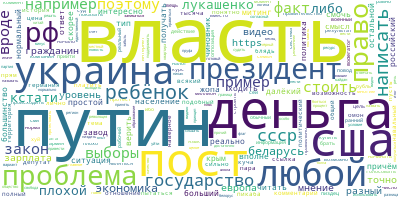

In [ ]:
wordcloud_visualization(pikdata_wo_swords)

In [ ]:
bigram = gensim.models.Phrases(pikdata_wo_swords, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[pikdata_wo_swords], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

pikdata_words_trigrams = make_trigrams(pikdata_wo_swords)

In [ ]:
pikdictionary = corpora.Dictionary(pikdata_words_trigrams)

pikcorpus = [pikdictionary.doc2bow(doc) for doc in pikdata_words_trigrams]

In [ ]:
piktfidf = gensim.models.TfidfModel(pikcorpus, id2word = pikdictionary)

In [ ]:
pikcorpus_tfidf = piktfidf[pikcorpus]

In [ ]:
print(len(pikcorpus))
print(len(pikcorpus_tfidf))

9591
9591


In [ ]:

tf_max = max([x for x in [max(doc, key= lambda x:x[1]) for doc in pikcorpus_tfidf]], key=lambda x:x[1])
tf_min = min([x for x in [min(doc, key= lambda x:x[1]) for doc in pikcorpus_tfidf]], key=lambda x:x[1])
print(tf_max, tf_min)
tfidf_range = np.arange(tf_min[1], tf_max[1], 0.005)

print(np.percentile(tfidf_range, 95), np.percentile(tfidf_range, 10))

(0, 1.0) (1069, 0.013731999149190861)
0.9494819991491906 0.11223199914919085


In [ ]:
low_value = np.percentile(tfidf_range, 10) 
high_value = np.percentile(tfidf_range, 95) 

filtered_corpus = []
for i in range(0, len(pikcorpus_tfidf)):
        
    filter_ids = [x[0] for x in pikcorpus_tfidf[i] if x[1] > 0.107 and x[1] < 0.948]
   
    new_bow = [word for word in pikcorpus[i] if word[0] in filter_ids]
      
    if new_bow:
        filtered_corpus.append(new_bow)

In [ ]:
filtered_corpus

[[(1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1)],
 [(38, 1), (39, 1), (40, 1)],
 [(41, 1), (42, 1), (43, 1)],
 [(44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(55, 1), (56, 1), (57, 1), (58, 1)],
 [(59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1)],
 [(79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1),
  (92, 1),
  (9

In [ ]:
# piktfidf = gensim.models.TfidfModel(filtered_corpus, id2word = pikdictionary)

In [ ]:
# pikcorpus_tfidf = piktfidf[filtered_corpus]

In [ ]:
# type(pikcorpus_tfidf)

gensim.interfaces.TransformedCorpus

In [ ]:
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=filtered_corpus,
                                           id2word=pikdictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/topic_modell

In [ ]:
# Show Topics
pprint(lda_model_tfidf.show_topics(formatted=False))

[(68,
  [('каки', 4.418717e-05),
   ('задолбать', 4.418717e-05),
   ('могем', 4.418717e-05),
   ('вьезд', 4.418717e-05),
   ('анема', 4.418717e-05),
   ('подработка', 4.418717e-05),
   ('обижать', 4.418717e-05),
   ('калин', 4.418717e-05),
   ('морзе', 4.418717e-05),
   ('азбука', 4.418717e-05)]),
 (37,
  [('каки', 4.418717e-05),
   ('задолбать', 4.418717e-05),
   ('могем', 4.418717e-05),
   ('вьезд', 4.418717e-05),
   ('анема', 4.418717e-05),
   ('подработка', 4.418717e-05),
   ('обижать', 4.418717e-05),
   ('калин', 4.418717e-05),
   ('морзе', 4.418717e-05),
   ('азбука', 4.418717e-05)]),
 (58,
  [('каки', 4.418717e-05),
   ('задолбать', 4.418717e-05),
   ('могем', 4.418717e-05),
   ('вьезд', 4.418717e-05),
   ('анема', 4.418717e-05),
   ('подработка', 4.418717e-05),
   ('обижать', 4.418717e-05),
   ('калин', 4.418717e-05),
   ('морзе', 4.418717e-05),
   ('азбука', 4.418717e-05)]),
 (73,
  [('каки', 4.418717e-05),
   ('задолбать', 4.418717e-05),
   ('могем', 4.418717e-05),
   ('вьезд

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_with_tfidf')

LDAvis_prepared = gensimvis.prepare(lda_model_tfidf, filtered_corpus, pikdictionary, mds='mmds')
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_with_no_tfidf' +'.html')
LDAvis_prepared

/opt/anaconda3/envs/topic_modelling_2/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
70     0.429070  0.020630       1        1  7.606798
40     0.163586  0.372230       2        1  6.599832
69     0.249755  0.223566       3        1  4.459268
3     -0.348201 -0.048736       4        1  3.794848
20     0.227096 -0.222813       5        1  3.515337
...         ...       ...     ...      ...       ...
37    -0.006818  0.000409      76        1  0.161342
43    -0.006818  0.000409      77        1  0.161342
45    -0.006818  0.000409      78        1  0.161342
49    -0.006818  0.000409      79        1  0.161342
79    -0.006818  0.000409      80        1  0.161342

[80 rows x 5 columns], topic_info=             Term         Freq        Total Category  logprob  loglift
1          власть  1142.000000  1142.000000  Default  30.0000  30.0000
170          пост  1180.000000  1180.000000  Default  29.0000  29.0000
162        деньга   856.000000   856.000000  Default  28.0000  28.0000
266       украина   812.000000   812.000000  Default  27.0000  27.0000
498       ребёнок   750.000000   750.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
25   работодатель     0.006719    95.092588  Topic80 -10.0271  -3.1283
26         разный     0.006719   205.094564  Topic80 -10.0271  -3.8969
27         сильно     0.006719   389.920164  Topic80 -10.0271  -4.5394
28         скорее     0.006719   152.553811  Topic80 -10.0271  -3.6010
29        сложный     0.006719    87.440091  Topic80 -10.0271  -3.0444

[3511 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
135      22  0.980332     http
200       9  0.992554    https
843       2  0.940627  автомат
554      38  0.984739    автор
277      47  0.974397      ага
...     ...       ...      ...
791       7  0.964868  чувство
978      37  0.983008   чёрный
874       2  0.975443    чётко
931      13  0.967592     штат
911       9  0.953021     яйцо

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[71, 41, 70, 4, 21, 48, 36, 45, 68, 78, 53, 42, 63, 77, 65, 40, 56, 52, 5, 67, 18, 13, 3, 37, 9, 54, 29, 76, 20, 16, 60, 64, 2, 73, 6, 12, 43, 22, 35, 72, 8, 51, 15, 17, 11, 75, 1, 55, 23, 14, 27, 61, 39, 47, 24, 69, 26, 25, 74, 66, 19, 10, 7, 79, 28, 31, 30, 49, 32, 62, 33, 59, 58, 57, 34, 38, 44, 46, 50, 80])

In [ ]:
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(filtered_corpus)) 


Perplexity:  -76.71535934165412


In [ ]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

In [ ]:
pikdata_vis

100228                                             \nЛоб?\n
105700    \nНу раз так всё просто иди выбери вменяемых п...
197325    \n\t\t\tХотел пойти в совок время, дс не вышло...
105193    \n\t\t\tЭкономика всегда превыше политики.\n\t...
129622    \n\t\t\tНу хоть сиски чуть отвисшие, и то радо...
                                ...                        
204255    \nВ данных политических реалиях - это сюрреали...
98999     \nвот именно, что никак. Точно так же как непь...
187298    \nЯ не про тебя, но#comment_91278474#comment_9...
103361    \nТоже вспоминаю 2009-2012, в каких обьемах лю...
148419    \nУж не знаю, что имел в виду губернатор, НО п...
Name: content, Length: 10000, dtype: object

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text").reset_index(drop=True)
    sent_topics_df = sent_topics_df.reset_index(drop=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=filtered_corpus, texts=pikdata_vis)


# df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_topic_sents_keywords.head(10)

Dominant_Topic1 Dominant_Topic2 %Topic_Contribution1 %Topic_Contribution2  \
0              77              70               0.7295               0.0227   
1              44              47               0.5561               0.0662   
2              70              40               0.0815               0.0645   
3              70              40               0.0815               0.0645   
4              10              20               0.5833               0.1051   
5              17              70                0.314               0.0569   
6              41               2               0.7556               0.0774   
7              51              17               0.6486               0.1117   
8              70              40               0.0815               0.0645   
9              63              70               0.6874               0.0258   

                                     Topic_Keywords1  \
0  власть, менять, выбрать, представитель, край, ...   
1  виноватый, знакомый, наверное, разный, месяц, ...   
2  пост, президент, мнение, вроде, комментарий, б...   
3  пост, президент, мнение, вроде, комментарий, б...   
4  нато, кремль, недовольный, неужели, справиться...   
5  интересно, образование, блядь, фраза, уничтожи...   
6  налог, предприятие, рабочий, выбор, местный, б...   
7  получать, ситуация, попасть, наверняка, вспомн...   
8  пост, президент, мнение, вроде, комментарий, б...   
9  хуй, вести, послать, свидетель, сказка, морзе,...   

                                     Topic_Keywords2  \
0  пост, президент, мнение, вроде, комментарий, б...   
1  украина, сильно, далёкий, протест, массовый, з...   
2  ссср, уровень, цена, платить, ибо, жрать, высо...   
3  ссср, уровень, цена, платить, ибо, жрать, высо...   
4  лукашенко, нормальный, показывать, нравиться, ...   
5  пост, президент, мнение, вроде, комментарий, б...   
6  зарплата, компания, государственный, средство,...   
7  интересно, образование, блядь, фраза, уничтожи...   
8  ссср, уровень, цена, платить, ибо, жрать, высо...   
9  пост, президент, мнение, вроде, комментарий, б...   

                                                text  
0                                           \nЛоб?\n  
1  \nНу раз так всё просто иди выбери вменяемых п...  
2  \n\t\t\tХотел пойти в совок время, дс не вышло...  
3  \n\t\t\tЭкономика всегда превыше политики.\n\t...  
4  \n\t\t\tНу хоть сиски чуть отвисшие, и то радо...  
5  \n\t\t\tТак не было же приватизаций, всплеска ...  
6  \nвот и было бы интересно глянуть в реальности...  
7  \nОтчисления отчислениями. Но налоги с зарплат...  
8  \nПопал в ту же ситуацию, только что вспомнил ...  
9  \nА зачем Европе или России подтягивать Белару...

In [ ]:
df_topic_sents_keywords.to_csv('./results/dominant_topic_with_tfidf_limit.csv', index= False)

In [ ]:
df_topic_sents_keywords.loc[2]["text"]

'\n\t\t\tХотел пойти в совок время, дс не вышло. Дворником хотел устроиться в Москве, ходил по жэкам да тсж месяц наверное, но не взяли. Много где слышал одну и ту же версию от разных людей - меня не взяли потому, что наебать меня сильно сложнее. То есть виноваты в том, что чурок засилье не сами сурки, а скорее власти и работодатели. Некоторые знакомы на стройку хотели устроиться, но так же не взяли, кстати.\n\t\t\t\t\t\t'

In [ ]:
df_topic_sents_keywords.loc[2]["Topic_Keywords2"]

'ссср, уровень, цена, платить, ибо, жрать, высокий, полностью, доллар, украинец'